# 《后来的我们》可视化

In [84]:
#coding:utf-8
import pandas as pd
from pyecharts import Bar
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sb
import re
import numpy as np
from PIL import Image
import jieba

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

## 加载数据
数据都已经保存在本地的*comment.csv*中，加载到工作区，需要注意的是因为csv中列是没有列名的，需要指定`header = -1`，从而确保数据从第一列（pandas默认将第一列加载为列名）。

In [85]:
df = pd.read_csv('comment.csv',  header=-1)
cols = ['index', 'comment', 'voting', 'rating', 'date']
df.columns = cols
df.head()

,index,comment,voting,rating,date
0,0,台词矫情的令人发指！,11071,较差,2018-04-23
1,1,刘若英对着镜头唱一遍后来我都觉得比这片子感动。,10731,较差,2018-04-28
2,2,现在还把北京设定为梦想之城的，大概受众也是瞄准了小镇青年吧（多次冲北京喊话真是挺尴尬的）。剧...,7325,较差,2018-04-23
3,3,毫无看点可言。剧情处处是硬伤！这是电影吗？这是PPT，刘小姐，还是回去唱歌吧。,5973,很差,2018-04-27
4,4,最好的是演员，周冬雨完全开辟出自己的戏路。小井进步惊人，已长出美丽。最差的是编剧，没有一场完...,6336,还行,2018-04-23


我们可以先查看前10条被认为最有用的评论

In [108]:
df['comment'][:10]

0                                           台词矫情的令人发指！
1                              刘若英对着镜头唱一遍后来我都觉得比这片子感动。
2    现在还把北京设定为梦想之城的，大概受众也是瞄准了小镇青年吧（多次冲北京喊话真是挺尴尬的）。剧...
3              毫无看点可言。剧情处处是硬伤！这是电影吗？这是PPT，刘小姐，还是回去唱歌吧。
4    最好的是演员，周冬雨完全开辟出自己的戏路。小井进步惊人，已长出美丽。最差的是编剧，没有一场完...
5    真的很讨厌卖情怀的电影，而且还有一个不是很有才华的歌手做导演，要不是主题曲我应该都不会想看。...
6    垃圾做作的电影这么多年了还在不断的重复搞这种烂片大晚上被抓住票房造假哈哈哈哈哈哈垃圾怎么包装...
7         从形式内容到档期营销，统统都是模仿当年的致青春，致青春票房年度第二，这部最终估计也不会差
8                            在我眼里第二个无问西东，投机取巧，毫无才华，对不起
9                               只有四个字，生拼硬凑！第一次看电影中途离场！
Name: comment, dtype: object

## 查看评论打分的分布情况

In [111]:
rating_series = df.groupby('rating')['rating'].count()
rating_series.index
# Index(['None', '力荐', '很差', '推荐', '较差', '还行'], dtype='object', name='rating')
ra = rating_series.sort_values(ascending = False)
ra

rating
很差      140
较差      121
还行      106
推荐       79
力荐       44
None     10
Name: rating, dtype: int64

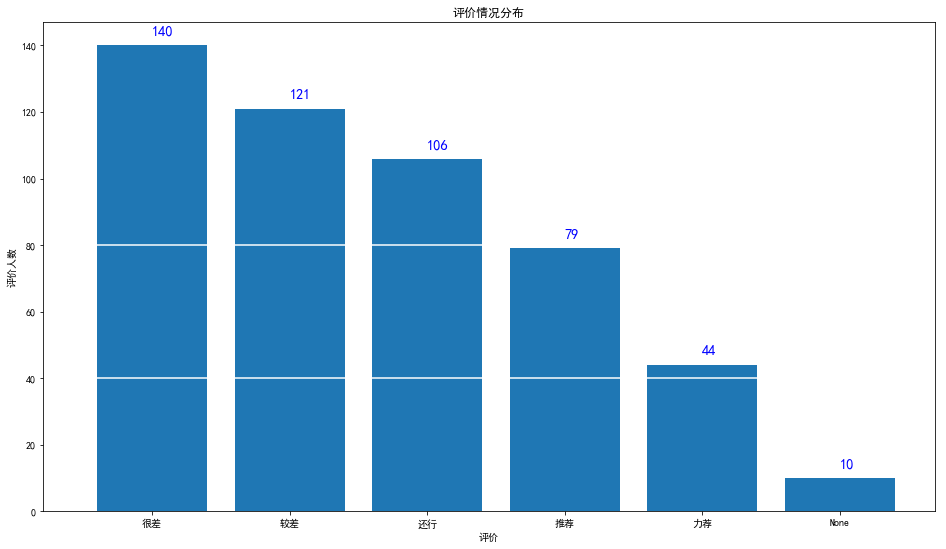

In [89]:
plt.figure(figsize = (16,9))
plt.bar(x = ra.index, height = ra)
plt.xlabel(u'评价')
plt.ylabel(u'评价人数')
plt.title('评价情况分布')
plt.hlines(40, -.5, 5.0, colors='w')
plt.hlines(80, -.5, 5.0, colors='w')
for i, v in enumerate(ra):
    plt.text(i, v + 3, str(v), color='blue', fontweight='bold', size = 'x-large')
# plt.axis('off')
plt.show()


可以看出很差和较差两根柱子都高耸入云，看起来评价的确是不大好，我们把很差和较差合并为差评后可以看见（下方饼图）：过半数人给出了差评及以下的评价

In [115]:
rating_series['差评'] = rating_series['很差'] + rating_series['较差']
ra_formatted = rating_series.sort_values(ascending = False)
del(ra_formatted['很差'])
del(ra_formatted['较差'])
ra_formatted

rating
差评      261
还行      106
推荐       79
力荐       44
None     10
Name: rating, dtype: int64

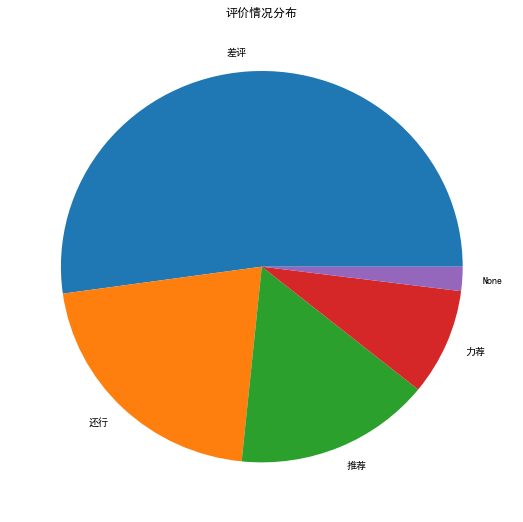

In [119]:
plt.figure(figsize = (9,9))
plt.pie(x = ra_formatted, labels = ra_formatted.index)
plt.title('评价情况分布')
plt.show()

## 查看评论数的时间分布情况

In [75]:
def ratings(df):
    n_rating = sum(df['rating'].value_counts())
    return (pd.Series(data = {
        'n_rating' : n_rating,
    }))

rating_by_date = df.groupby(['date', 'rating']).apply(ratings).reset_index()
rating_by_date = rating_by_date.pivot(index='date', columns='rating', values='n_rating')
rating_by_date

rating,None,力荐,很差,推荐,较差,还行
date,,,,,,
2018-04-10,1.0,NaN,NaN,NaN,NaN,NaN
2018-04-17,NaN,NaN,NaN,1.0,NaN,NaN
2018-04-18,NaN,1.0,NaN,NaN,NaN,NaN
2018-04-19,NaN,NaN,NaN,1.0,NaN,NaN
2018-04-21,NaN,NaN,NaN,NaN,NaN,1.0
2018-04-23,3.0,4.0,NaN,9.0,5.0,4.0
2018-04-24,NaN,NaN,NaN,1.0,2.0,2.0
2018-04-25,NaN,NaN,NaN,2.0,NaN,NaN
2018-04-26,NaN,NaN,1.0,1.0,NaN,1.0


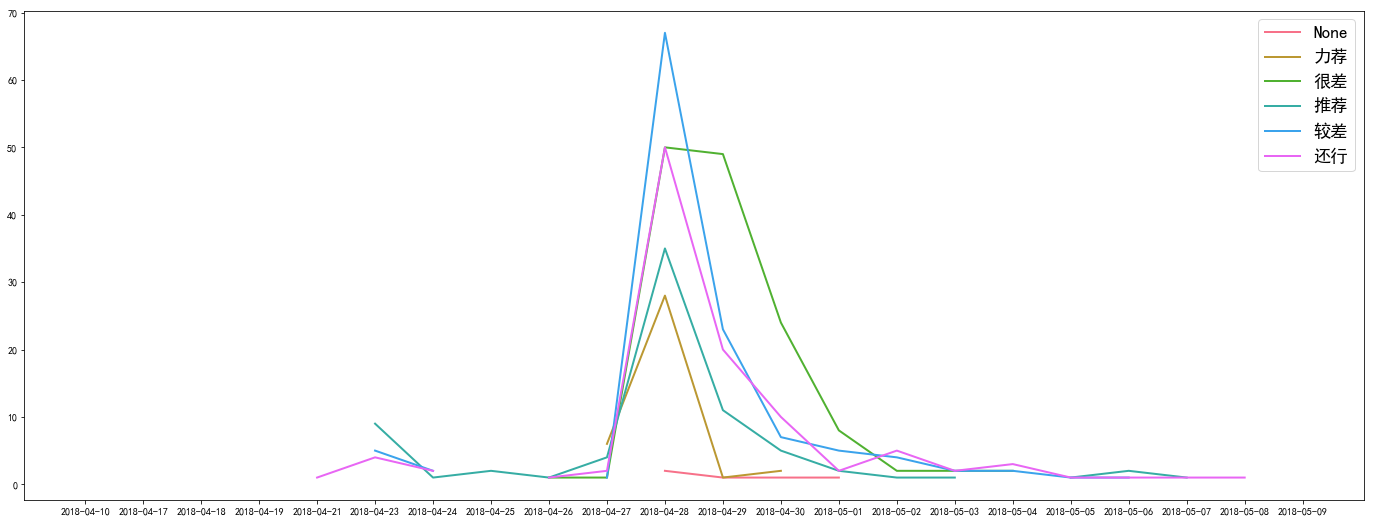

In [95]:
plt.figure(figsize = (24,9))
cc = sb.color_palette('husl')
for c,col in zip(cc,rating_by_date.columns):
    plt.plot(rating_by_date.index, rating_by_date[col], linewidth = 2, c = c)
plt.legend(loc=1, fontsize = 'xx-large')

## 生成词云
词云是由两部分构成，第一部分使用jieba分词将评论截断，这是有必要的，因为wordcloud对中文的分词处理得不是很好；第二部分是用wordcloud生成词云，并保存到本地

In [31]:
content = "".join(df.comment)
rubbish = re.compile(r'<aclass=".*?></a>')
content_text = re.sub(rubbish, '', content)
content_text[:100]

'台词矫情的令人发指！刘若英对着镜头唱一遍后来我都觉得比这片子感动。现在还把北京设定为梦想之城的，大概受众也是瞄准了小镇青年吧（多次冲北京喊话真是挺尴尬的）。剧情拖太长，唯一的泪点还是田壮壮演的老爸，周'

In [104]:
cut_content = jieba.cut(content_text, cut_all=True)
content_cut = " ".join(list(cut_content))
# content_cut

词云的可视化

中文里有许多助词比如“还是”，“真的”，“这个”这些是没有多大实际意义的词，我们可以通过停用词过滤掉这部分词汇。

In [96]:
# 设置停用词
stopwords = set(STOPWORDS)
stopwords = [u'还是',u'真的',u'如果',u'看到',u'这个',u'我们',u'可以', u'应该',u'不是',u'觉得',u'但是',u'有点', u'本来',u'不过',u'很多',u'然后',u'那么',u'所以',u'开始',u'现在',u'一点',u'就是',u'这么',u'一个',u'虽然',u'不会',u'多少',u'以为',u'因为',u'两个',u'真是',u'一部',u'同样',u'只是', u'还有',u'这样',u'一直',u'一颗',u'一些',u'所有',u'确实',u'只能',u'太多',u'什么',]

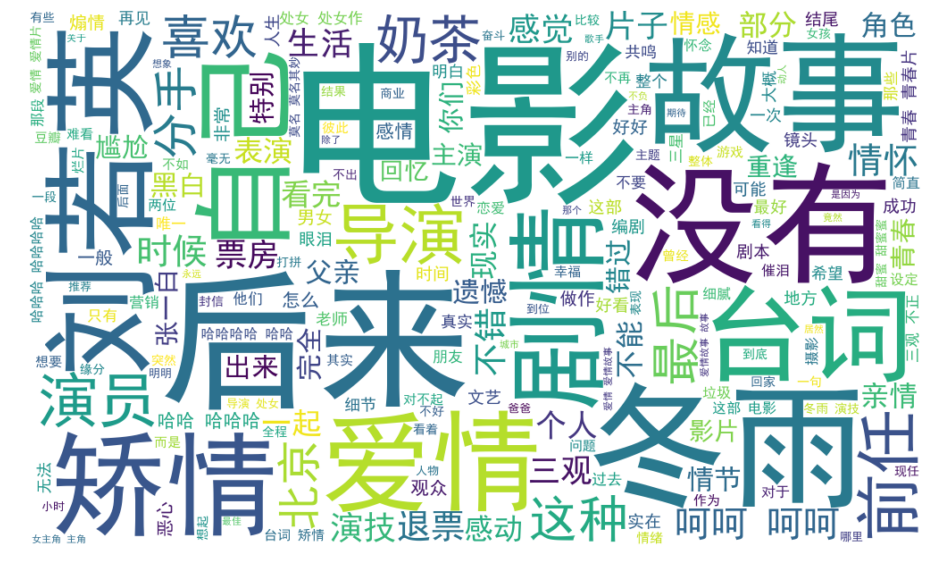

In [97]:
wordcloud = WordCloud(background_color="white", width=1000, height = 600, font_path=r"C:\simhei.ttf",max_words=200, stopwords=stopwords).generate(content_cut)
plt.figure(figsize = (16,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

使用奶茶作为背景图片生成的词云

(-0.5, 1706.5, 1706.5, -0.5)

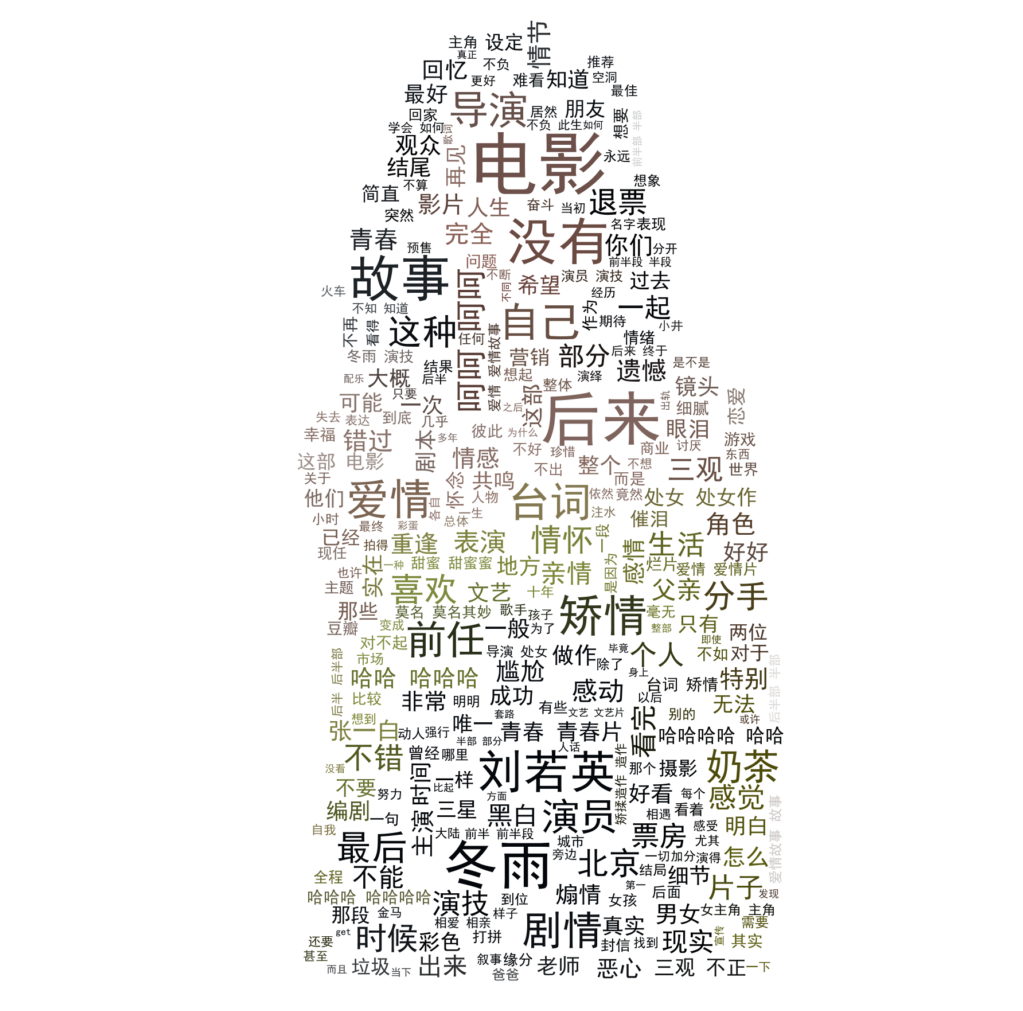

In [101]:
naicha_coloring = np.array(Image.open("naicha.jpg"))

# 你可以通过 mask 参数 来设置词云形状
wc = WordCloud(background_color="white", max_words=300, mask=naicha_coloring,
               stopwords=stopwords, max_font_size=120, font_path=r"C:\simhei.ttf", random_state=42)
wc.generate(content_cut)

# 我们还可以直接在构造函数中直接给颜色
# 通过这种方式词云将会按照给定的图片颜色布局生成字体颜色策略

# create coloring from image
image_colors = ImageColorGenerator(naicha_coloring)
plt.figure(figsize = (32,18))
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

## 保存到本地

In [103]:
wc_recolor = wc.recolor(color_func=image_colors)
wc_recolor.to_file('wordCloud.png')